## Helper functions & imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.integrate

def compare_fit(x, fit_y, method: str=""):
    """
    plots your fit function into the histograms
    x is your linspace of x values.
    fit_y is your array of y values.
    The "method" parameter is just to put it in the title of the plot
    Returns n, which is what plt_hist returns in an array: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    """
    fig,ax=plt.subplots(1, 4, figsize=(15,4), constrained_layout=True)
    for k,i in enumerate(bins):
        n = ax[k].hist(s, i,color='purple', density=True) # By the time this func is called, s will be known.
        ax[k].plot(x, fit_y, color='orange') # Plot the fit function
    fig.suptitle(f"Histograms of mixed data - {method}")
    plt.show()
    return n

bins = [5,10,50, 100] # Amount of bins used for the histograms. Given in the exercise.

# Our fit function that we use everywhere; a=lambda1, b=lambda2.
f = lambda x,a, b: 0.5*(a*np.exp(-a*x) + b*np.exp(-b*x))

## Generating data

In [20]:
#Generating the two random datasets of exponential distributions (lambda=10,lambda=50)
s1 = np.random.exponential((1/10),1000)
s2 = np.random.exponential((1/50),1000)
#mixing data sets
s = np.append(s1, s2)

## Method of Moments

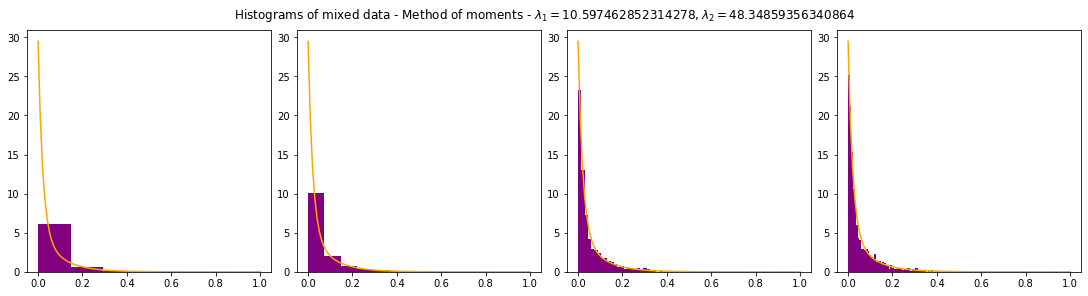

In [21]:
def k_moment(data, k=1):
    """
        This function returns the estimate of the kth moment of the data set.
    """
    n=len(data)
    sum=np.sum(data**k)
    return (1/n)*sum

#We are trying to estimate two parameters so we only need 2 moments.
(m1,m2)= (k_moment(s,1),k_moment(s,2))

# Using the formulas we derived:
lambda1=(m1+np.sqrt(0.5*m2-m1**2))**(-1)
lambda2=(m1-np.sqrt(0.5*m2-m1**2))**(-1)

x= np.linspace(0,1,100)

# Here we just wanna plot but the hist_values and bin_edges will be used later in the least squares method.
n = compare_fit(x, f(x, lambda1, lambda2), f"Method of moments - $\lambda_1 = {lambda1}, \lambda_2 = {lambda2}$")
hist_values = n[0]; bin_edges = n[1]

## Method of Least Squares

The main ideas were taken from the lecturer's notebook, with approval of our TA. Though we did *not* copy paste. We wrote it ourselves.

### Helper functions

In [22]:
def bin_probability(params, f, bin_edges):
    """
    Gives you the probability associated with each bin given a fitting function (PDF) 
    by integration of the function over the bin.

    Arguments:
        params          (array-like)                The parameters that the fitting function f takes                     
        f               (function)                  The fitting function that we want to test the parameters on
        bin_edges       (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
    Returns:
        integral_value  (array-like)                Array with the probability of each bin.

    """

    int_f = lambda x: f(x,params[0], params[1]) # Evaluates PDF for integration purposes

    integral_val = np.empty(0)

    for a,b in np.nditer([bin_edges[:-1],bin_edges[1:]]):   # a and b will be the integration bounds.
        val = scipy.integrate.quad(int_f,a,b)
        integral_val = np.append(integral_val,val)
    return integral_val

def res(params, f, bin_edges, hist, yerr, integration: bool=False):
    """

    Calculates the chi squared value of certain parameters for fit function s on histogram hist.

    Arguments:
            params      (array-like)                The parameters that the fitting function f takes                     
            f           (function)                  The fitting function that we want to test the parameters on
            bin_edges   (array-like)                Array of bin edges as returned by plt.hist() or the numpy equivalent
            hist        (array-like)                Array of heights of the histogram
            yerr        (array-like)                Dataset containing the corresponding error of every value.
            integration (boolean)                   Whether to use integration for bin probabilities. Defaults to false.
    Returns:
            result  (float)                         The chi squared value of the parameters on function f fitted over the histogram.

    """
    result = 0
    cbins = (bin_edges[:-1]+bin_edges[1:])/2   # calculate centres of the bins
    bin_width = bin_edges[1:] - bin_edges[:-1]
    
    # Either integrate over the bins or just evaluate the fit function * bin width at every bin.
    # Prediction here is for the total probability between the two bin edges.
    prediction = bin_probability(params, f, bin_edges) if integration else bin_width*f(cbins, params[0], params[1]) 

    for i in range(len(hist)):
        result += ((bin_width*hist[i] - prediction[i])**2/(yerr[i])**2)
    return result

i_nonzero = hist_values !=0 # You don't wanna take places into account where the histogram is 0
x = np.linspace(0,1, len(hist_values[i_nonzero]))
starting_values = (10,50)


### Without statistical error

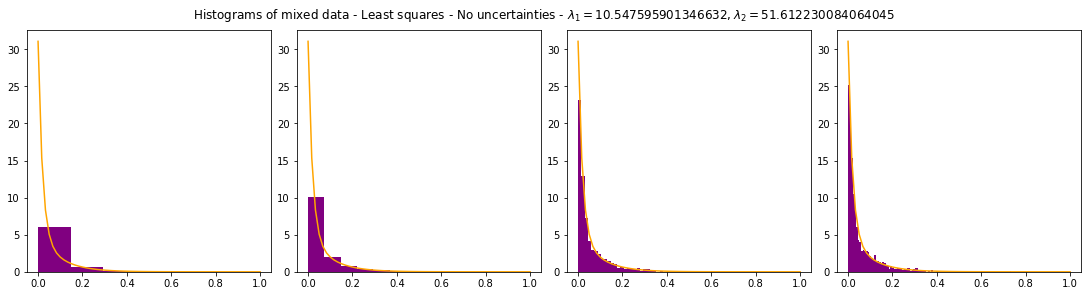

In [23]:
yerr = [1 for i in range(len(hist_values[i_nonzero]))]
result = scipy.optimize.least_squares(res, starting_values, args=(f,bin_edges, hist_values[i_nonzero], yerr), bounds=(1,100))
dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), f"Least squares - No uncertainties - $\lambda_1 = {result.x[0]}, \lambda_2 = {result.x[1]}$")

### With statistical error

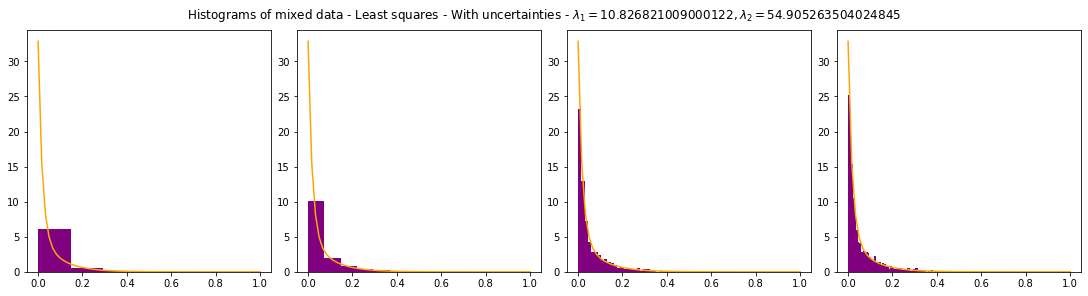

In [27]:
# Let's care about statistical uncertainties now.
yerr = np.sqrt(hist_values[i_nonzero]) # The formula for chisquared now is (O-E)^2/E but the E (expected value) is squared in the formula we wrote so here we compensate for that.
result = scipy.optimize.least_squares(res, (starting_values), args=(f,bin_edges, hist_values[i_nonzero], yerr), bounds=(1,100))
dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), f"Least squares - With uncertainties - $\lambda_1 = {result.x[0]}, \lambda_2 = {result.x[1]}$")

### With integration

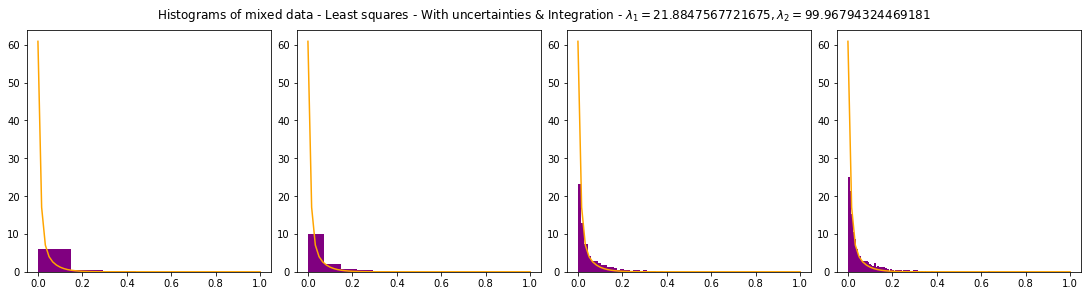

In [28]:
# What's the difference? The argument "integration" is set to "True" in the residual function now.
result = scipy.optimize.least_squares(res, (10,50), args=(f,bin_edges, hist_values[i_nonzero], yerr, True), bounds=(1,100)) # res_int is the function that uses integration for the residual
dummyvar = compare_fit(x, f(x,result.x[0],result.x[1]), f"Least squares - With uncertainties & Integration - $\lambda_1 = {result.x[0]}, \lambda_2 = {result.x[1]}$")

## Method of Maximum Likelyhood